# Evaluate models in experimental data

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Defines imports
import ipykernel
import os
import sys
module_path = os.path.abspath(os.path.join('/home/gustavo/Gdrive/Stanford/Lab/ODF_prediction/cleaned_scripts/utilities')) # or the path to your source code
sys.path.insert(0, module_path)

import numpy as np
import keras
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import os
import random
import pickle

from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as scis
import scipy.io as scio


from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

import model_functions as mfunc
from model_functions import final_layer_gamma
from model_functions import negative_log_likelihood_loss_gamma

import evaluation

In [52]:
# Defines constants
_DATASET_LIST = ['dog','dog_panda','dog_sealion_panda','dog_sealion','dog_goldfish_hotpot_panda_sealion_terrier', 'goldfish_hotpot_panda_sealion_terrier']
_DATASET_FOLDER = '/home/gustavo/Gdrive/Stanford/Lab/ODF_prediction/datasets/experimental'
_MODEL_FOLDER = '/home/gustavo/Gdrive/Stanford/Lab/ODF_prediction/cleaned_scripts/pretrained_models'
_RESULTS_FOLDER = '/home/gustavo/Gdrive/Stanford/Lab/ODF_prediction/cleaned_scripts/experimental_results'
_TL_MODEL_FOLDER = '/home/gustavo/Gdrive/Stanford/Lab/ODF_prediction/cleaned_scripts/tf_models'
_NUM_RUNS = 2
_LEARNING_RATE = 0.0015
_NUM_EPOCHS = 2500
_BATCH_SIZE = 16
_LAYERS_FREEZE = [0,1,2,3,6,7,8,9]

### Load dataset

In [59]:
dataset_name = 'mouse_3regions'
file_name = os.path.join(_DATASET_FOLDER,f'{dataset_name}.pkl')
with open(file_name, 'rb') as file:
    data_save = pickle.load(file)

# Unpacks the data
test_data = data_save['test']
x_test = test_data['x_scaled']
diameter_samples_test = test_data['diameter_samples']
gratio_samples_test = test_data['gratio_samples']
params_test = test_data['params_gt']

# Defines and compiles network
num_features = x_test.shape[1]

### Evaluation

Processing dog, run 0


/home/gustavo/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:1293: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)


NameError: name 'names' is not defined

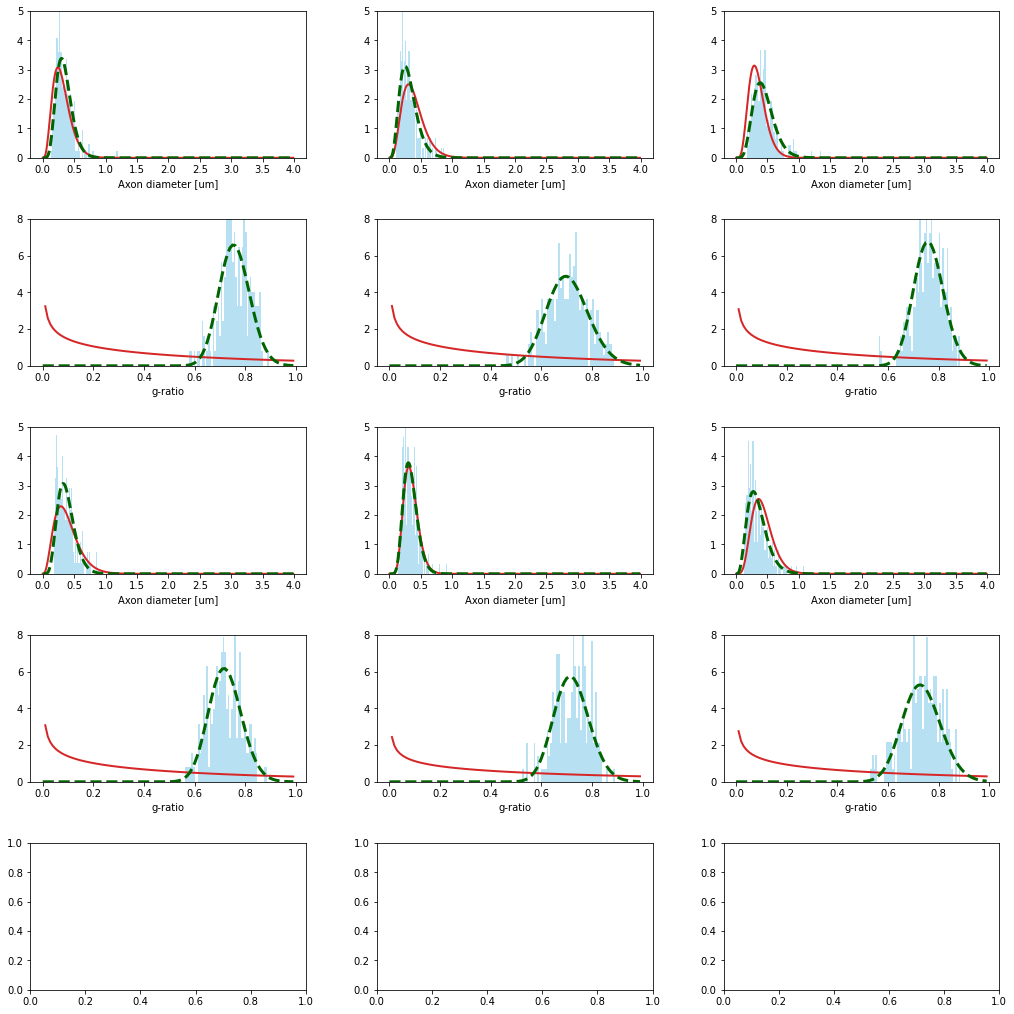

In [70]:
import pandas as pd
df_metrics = pd.DataFrame()
column_names = ['pretrain_set','run_num']+['alpha_axon', 'beta_axon', 'PvF_axon',
                         'PvH_axon','FvH_axon']+['alpha_g', 'beta_g', 'PvF_g',
                         'PvH_g','FvH_g']
df_metrics = pd.DataFrame(columns=column_names)

custom_objects = {"final_layer_gamma": final_layer_gamma, 
                  "negative_log_likelihood_loss_gamma": negative_log_likelihood_loss_gamma}

for dataset_name in _DATASET_LIST:
    # Load model
    for iteration in range(_NUM_RUNS):
        run_name = f'experimental_{dataset_name}_{iteration}'
        path_to_model = os.path.join(_TL_MODEL_FOLDER,dataset_name,run_name)
        print(f'Processing {dataset_name}, run {iteration}')
        with keras.utils.custom_object_scope(custom_objects):
            model = keras.models.load_model(path_to_model)
        test_pred = model.predict(x_test,verbose=0)
        test_pred = np.concatenate(test_pred,axis=1)
        all_metrics = get_all_metrics(test_pred,params_test,diameter_samples_test,gratio_samples_test)
        new_row = {'pretrain_set':dataset_name,'run_num':iteration}
        for ii,metric in enumerate(column_names):
            if ii<2:
                continue
            new_row[metric] = all_metrics[ii-2]
        df_metrics = df_metrics.append(new_row, ignore_index = True)
        
        plot_distributions(test_pred, params_test, diameter_samples_test,gratio_samples_test)

In [61]:
def get_maes(pred,groundtruth):
    abs_difference = np.abs(pred-groundtruth)
    maes = np.mean(abs_difference,axis=0)
    perc_err = np.round(np.mean(abs_difference/groundtruth,axis=0)*100.0,1)
    return perc_err
        
from scipy.spatial import distance
def compute_JSD_fitting(concentration_pred,rate_pred,concentration_gt,rate_gt):
    x_axis = np.arange(0,30,0.01)
    curve_axon_pred = tfp.distributions.Gamma(concentration=concentration_pred,rate=rate_pred).prob(x_axis)
    curve_axon_gt = tfp.distributions.Gamma(concentration=concentration_gt,rate=rate_gt).prob(x_axis)
    return distance.jensenshannon(curve_axon_pred, curve_axon_gt)

def compute_JSD_samples(concentration_pred,rate_pred,samples):
    x_axis = np.arange(0,30,0.01)
    bins = np.arange(0,30.01,0.01)

    curve_axon_pred = tfp.distributions.Gamma(concentration=concentration_pred,rate=rate_pred).prob(x_axis)
    hist_samples,_ = np.histogram(samples, bins=bins, density=True)
    return distance.jensenshannon(curve_axon_pred, hist_samples)

def get_all_metrics(predictions,real_parameters,axon_samples,gratio_samples):
    divergence_metrics = []
    for pred_param,gt_param, axon_sample, g_sample in zip (predictions, real_parameters, axon_samples, gratio_samples):
        jsd_fit_diam = compute_JSD_fitting(pred_param[0],pred_param[1],gt_param[0],gt_param[1])
        jsd_samp_diam = compute_JSD_samples(pred_param[0],pred_param[1],axon_sample)
        jsd_gt_diam = compute_JSD_samples(gt_param[0],gt_param[1],axon_sample)

        jsd_fit_g = compute_JSD_fitting(pred_param[2],pred_param[3],gt_param[2],gt_param[3])
        jsd_samp_g = compute_JSD_samples(pred_param[2],pred_param[3],g_sample)
        jsd_gt_g = compute_JSD_samples(gt_param[2],gt_param[3],g_sample)
        divergence_metrics.append(np.array([jsd_fit_diam,jsd_samp_diam,jsd_gt_diam,jsd_fit_g,jsd_samp_g,jsd_gt_g]))
    divergence_metrics = np.array(divergence_metrics)
    divergence_metrics = np.mean(divergence_metrics,axis=0)
    perc_err = get_maes(predictions,real_parameters)
    all_metrics = [np.array(perc_err[0:2]),divergence_metrics[0:3],np.array(perc_err[2:]),divergence_metrics[3:]]
    return np.hstack(all_metrics)
    


In [69]:
def plot_distributions(test_pred, gt_test, axon_samples_mouse_test,gratio_samples_mouse_test):
    _NUM_SAMPLES = 400
    def plot_axon_diameter(pred, gt, diameter_samples, selected_index, ax_in):

            predictions = pred[selected_index,:]
            gt_params = gt[selected_index,:]
            x_axis = np.arange(0,4,0.01)
            curve_axon_pred = tfp.distributions.Gamma(concentration=predictions[0],rate=predictions[1]).prob(x_axis)
            curve_axon_gt = tfp.distributions.Gamma(concentration=gt_params[0],rate=gt_params[1]).prob(x_axis)


            ax_in.plot(x_axis,curve_axon_pred, linewidth=2, color='tab:red',label='predicted')
            ax_in.plot(x_axis,curve_axon_gt, linewidth=3, color='darkgreen',label='groundtruth',linestyle='--')
            ax_in.hist(diameter_samples[selected_index,:_NUM_SAMPLES],50,density=1,label='samples',color='skyblue',alpha=0.6)
            ax_in.set_xlabel('Axon diameter [um]')
            ax_in.set_ylim([0,5])

    def plot_gratio(pred, gt, gratio_samples, selected_index, ax_in):

            predictions = pred[selected_index,:]
            gt_params = gt[selected_index,:]
            x_axis2 = np.arange(0,1,0.01)
            curve_g_pred = tfp.distributions.Gamma(concentration=predictions[2],rate=predictions[3]).prob(x_axis2)
            curve_g_gt = tfp.distributions.Gamma(concentration=gt_params[2],rate=gt_params[3]).prob(x_axis2)

            ax_in.plot(x_axis2,curve_g_pred, linewidth=2, color='tab:red',label='predicted')
            ax_in.plot(x_axis2,curve_g_gt, linewidth=3, color='darkgreen',label='groundtruth',linestyle='--')
            ax_in.hist(gratio_samples[selected_index,:_NUM_SAMPLES],50,density=1,label='samples',color='skyblue',alpha=0.6)
            ax_in.set_xlabel('g-ratio')
            ax_in.set_ylim([0,8])

    fig, axs = plt.subplots(5, 3,figsize=(15, 15))
    fig.tight_layout(pad=4.0)

    abs_difference = np.abs(test_pred-gt_test)
    maes = np.mean(abs_difference,axis=0)
    perc_err = np.round(np.mean(abs_difference/gt_test,axis=0)*100.0,1)


    for ii in range(3):
        plot_axon_diameter(test_pred, gt_test, axon_samples_mouse_test, ii, axs[0,ii])
        plot_gratio(test_pred, gt_test, gratio_samples_mouse_test, ii, axs[1,ii])

    for ii in range(3,6):
        plot_axon_diameter(test_pred, gt_test, axon_samples_mouse_test, ii, axs[2,ii-3])
        plot_gratio(test_pred, gt_test, gratio_samples_mouse_test, ii, axs[3,ii-3])

    axs[4,1].bar(names, perc_err, color ='lightcoral', width = 0.6)
    axs[4,1].set_xticklabels(names)
    axs[4,1].set_ylabel('Percent error')
    axs[4,1].set_ylim([0,40])
    fig.delaxes(axs[4,0])
    fig.delaxes(axs[4,2])

    axs[0,0].set_title('(a) WT Mouse, Genu',fontsize=16)
    axs[0,1].set_title('(b) WT Mouse, Body',fontsize=16)
    axs[0,2].set_title('(c) WT Mouse, Splenium',fontsize=16)

    axs[1,0].set_title('(d) WT Mouse, Genu',fontsize=16)
    axs[1,1].set_title('(e) WT Mouse, Body',fontsize=16)
    axs[1,2].set_title('(f) WT Mouse, Splenium',fontsize=16)

    axs[2,0].set_title('(g) SZ Mouse, Genu',fontsize=16)
    axs[2,1].set_title('(h) SZ Mouse, Body',fontsize=16)
    axs[2,2].set_title('(i) SZ Mouse, Splenium',fontsize=16)

    axs[3,0].set_title('(j) SZ Mouse, Genu',fontsize=16)
    axs[3,1].set_title('(k) SZ Mouse, Body',fontsize=16)
    axs[3,2].set_title('(l) SZ Mouse, Splenium',fontsize=16)

    axs[4,1].set_title('(m) Percent Error in parameter prediction',fontsize=16)

    plt.show()

In [65]:
display(df_metrics)

,pretrain_set,run_num,alpha_axon,beta_axon,PvF_axon,PvH_axon,FvH_axon,alpha_g,beta_g,PvF_g,PvH_g,FvH_g
0,dog,0,27.5,25.0,0.139885,0.299341,0.257763,99.4,99.4,NaN,NaN,0.183213
1,dog,1,23.2,24.2,0.146273,0.297527,0.257763,99.4,99.4,NaN,NaN,0.183213
2,dog,2,23.6,19.0,0.151340,0.299022,0.257763,99.4,99.4,NaN,NaN,0.183213
3,dog,3,28.2,23.2,0.161016,0.311379,0.257763,99.4,99.4,NaN,NaN,0.183213
4,dog,4,24.5,20.4,0.143190,0.299534,0.257763,99.4,99.4,NaN,NaN,0.183213
...,...,...,...,...,...,...,...,...,...,...,...,...
115,goldfish_hotpot_panda_sealion_terrier,15,24.4,15.9,0.154855,0.300725,0.257763,34.0,30.2,0.242019,0.309750,0.183213
116,goldfish_hotpot_panda_sealion_terrier,16,23.4,11.8,0.168968,0.316250,0.257763,33.8,30.7,0.204705,0.280733,0.183213
117,goldfish_hotpot_panda_sealion_terrier,17,20.5,8.2,0.177541,0.320769,0.257763,35.6,32.0,0.201583,0.275700,0.183213
118,goldfish_hotpot_panda_sealion_terrier,18,25.5,15.5,0.170874,0.321954,0.257763,35.3,31.5,0.208337,0.290930,0.183213


In [63]:
df_metrics.groupby('pretrain_set').aggregate('mean')

,alpha_axon,beta_axon,PvF_axon,PvH_axon,FvH_axon,alpha_g,beta_g,PvF_g,PvH_g,FvH_g
pretrain_set,,,,,,,,,,
dog,23.185,20.505,0.149962,0.301068,0.257763,99.400,99.400,NaN,NaN,0.183213
dog_goldfish_hotpot_panda_sealion_terrier,26.005,20.345,0.153375,0.300085,0.257763,32.660,31.640,0.143069,0.240591,0.183213
dog_panda,22.435,22.630,0.251049,0.371355,0.257763,52.340,48.330,0.212900,0.272616,0.183213
dog_sealion,23.910,26.355,0.187407,0.323986,0.257763,35.860,30.400,0.219788,0.290096,0.183213
dog_sealion_panda,17.105,22.835,0.167764,0.313079,0.257763,24.125,20.475,0.198521,0.281082,0.183213
goldfish_hotpot_panda_sealion_terrier,23.995,16.710,0.171418,0.315659,0.257763,33.500,30.530,0.217112,0.291980,0.183213


In [64]:
df_metrics.groupby('pretrain_set').aggregate('std')

,alpha_axon,beta_axon,PvF_axon,PvH_axon,FvH_axon,alpha_g,beta_g,PvF_g,PvH_g,FvH_g
pretrain_set,,,,,,,,,,
dog,2.793654,4.117929,0.014573,0.006362,0.0,0.000000,0.000000,NaN,NaN,0.0
dog_goldfish_hotpot_panda_sealion_terrier,3.073567,4.500231,0.015730,0.010005,0.0,3.493211,3.236210,0.019270,0.012834,0.0
dog_panda,3.596676,3.769141,0.023915,0.018353,0.0,4.804428,4.279584,0.019830,0.015071,0.0
dog_sealion,2.483398,3.698858,0.021798,0.015426,0.0,2.891075,2.470457,0.021971,0.017455,0.0
dog_sealion_panda,2.670201,4.362070,0.023881,0.015333,0.0,3.526124,2.483180,0.029604,0.023974,0.0
goldfish_hotpot_panda_sealion_terrier,4.358353,5.692275,0.023710,0.014436,0.0,2.948327,2.686242,0.018589,0.011885,0.0
